# EXAMPLE : Using aweSOM to perform SCE analysis on decaying plasma turbulence simulation
For more details about the data, see Ha et al. (2024) [add link here]

After running that, load one of the objects for further analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

Load simulation data to compare

You need a few things here. First is the original hdf5 snapshot of the simulation, `d3x128s10/flds_5000.h5`, second is the configuration file to read the snapshot, `d3x128s10.ini`. 

Download the files from [link to zenodo archive], then provide the path to the files with `path`.

In [7]:
original_path = os.getcwd()
print('Current working directory:', original_path)

Current working directory: /mnt/home/tha10/git_repos/aweSOM/examples/plasma-turbulence


In [8]:
import read_turbulence_data as rtd
conf = "d3x128s10.ini"
path = '/mnt/home/tha10/ceph/sim_snapshots/'# "/Users/tvh0021/Documents/Archive/"
filename = "flds_5000.h5"
lap = 5000

decay_turb = rtd.GetH5Data(path, filename, conf, lap)
# get the data
dx = 10./3.
decay_turb.return_basic_j_fields(dx)
decay_turb.return_all_other_fields()

d3x128s10
plotting j_par
flds


/mnt/home/tha10/git_repos/aweSOM/examples/plasma-turbulence/initialize_turbulence.py:175: RuntimeWarning: divide by zero encountered in scalar divide
  A = 0.1 * self.g0 / self.gammarad**2  # definition we use in Runko


Refer to `examples/slurm_scripts/submit_plasma.slurm` for an example of the command to run the parameter scan on a set of aweSOM realizations.

You will need the file `features_2j1b1e0r_5000_jasym.h5` from [link to file]. You can also generate different sets of features using the `examples/plasma-turbulence/obtain_features.py` file.

`examples/plasma-turbulence/run_plasma_som.py` will run multiple aweSOM realizations, using the `multiprocessing` package, so the more cores available, the faster it should run.

The result of this run is a list of files with names `labels.*` and `som_object.*`. The labels are final clustering results, while the objects are pickle files of the entire trained lattice that can be modified.

To run the SCE clustering, import `cuda` to use GPU acceleration. GPU is not necessary for the Iris dataset but is absolutely necessary here ($N_{\rm iris} = 150$, $N_{\rm plasma} = 128^3$).

Run the SCE $G_{\rm sum}$ calculation with `python3 [path_to_aweSOM]/aweSOM/src/aweSOM/sce.py --subfolder SCE --dims 2097152`. Make sure that the first line of output is ``Using JAX for GPU computation``

Using one NVIDIA V-100 GPU, this should not take more than 3 minutes to complete. All cluster masks and `multimap_mappings.txt` are saved in `SCE/`

Now visualize $G_{\rm sum}$

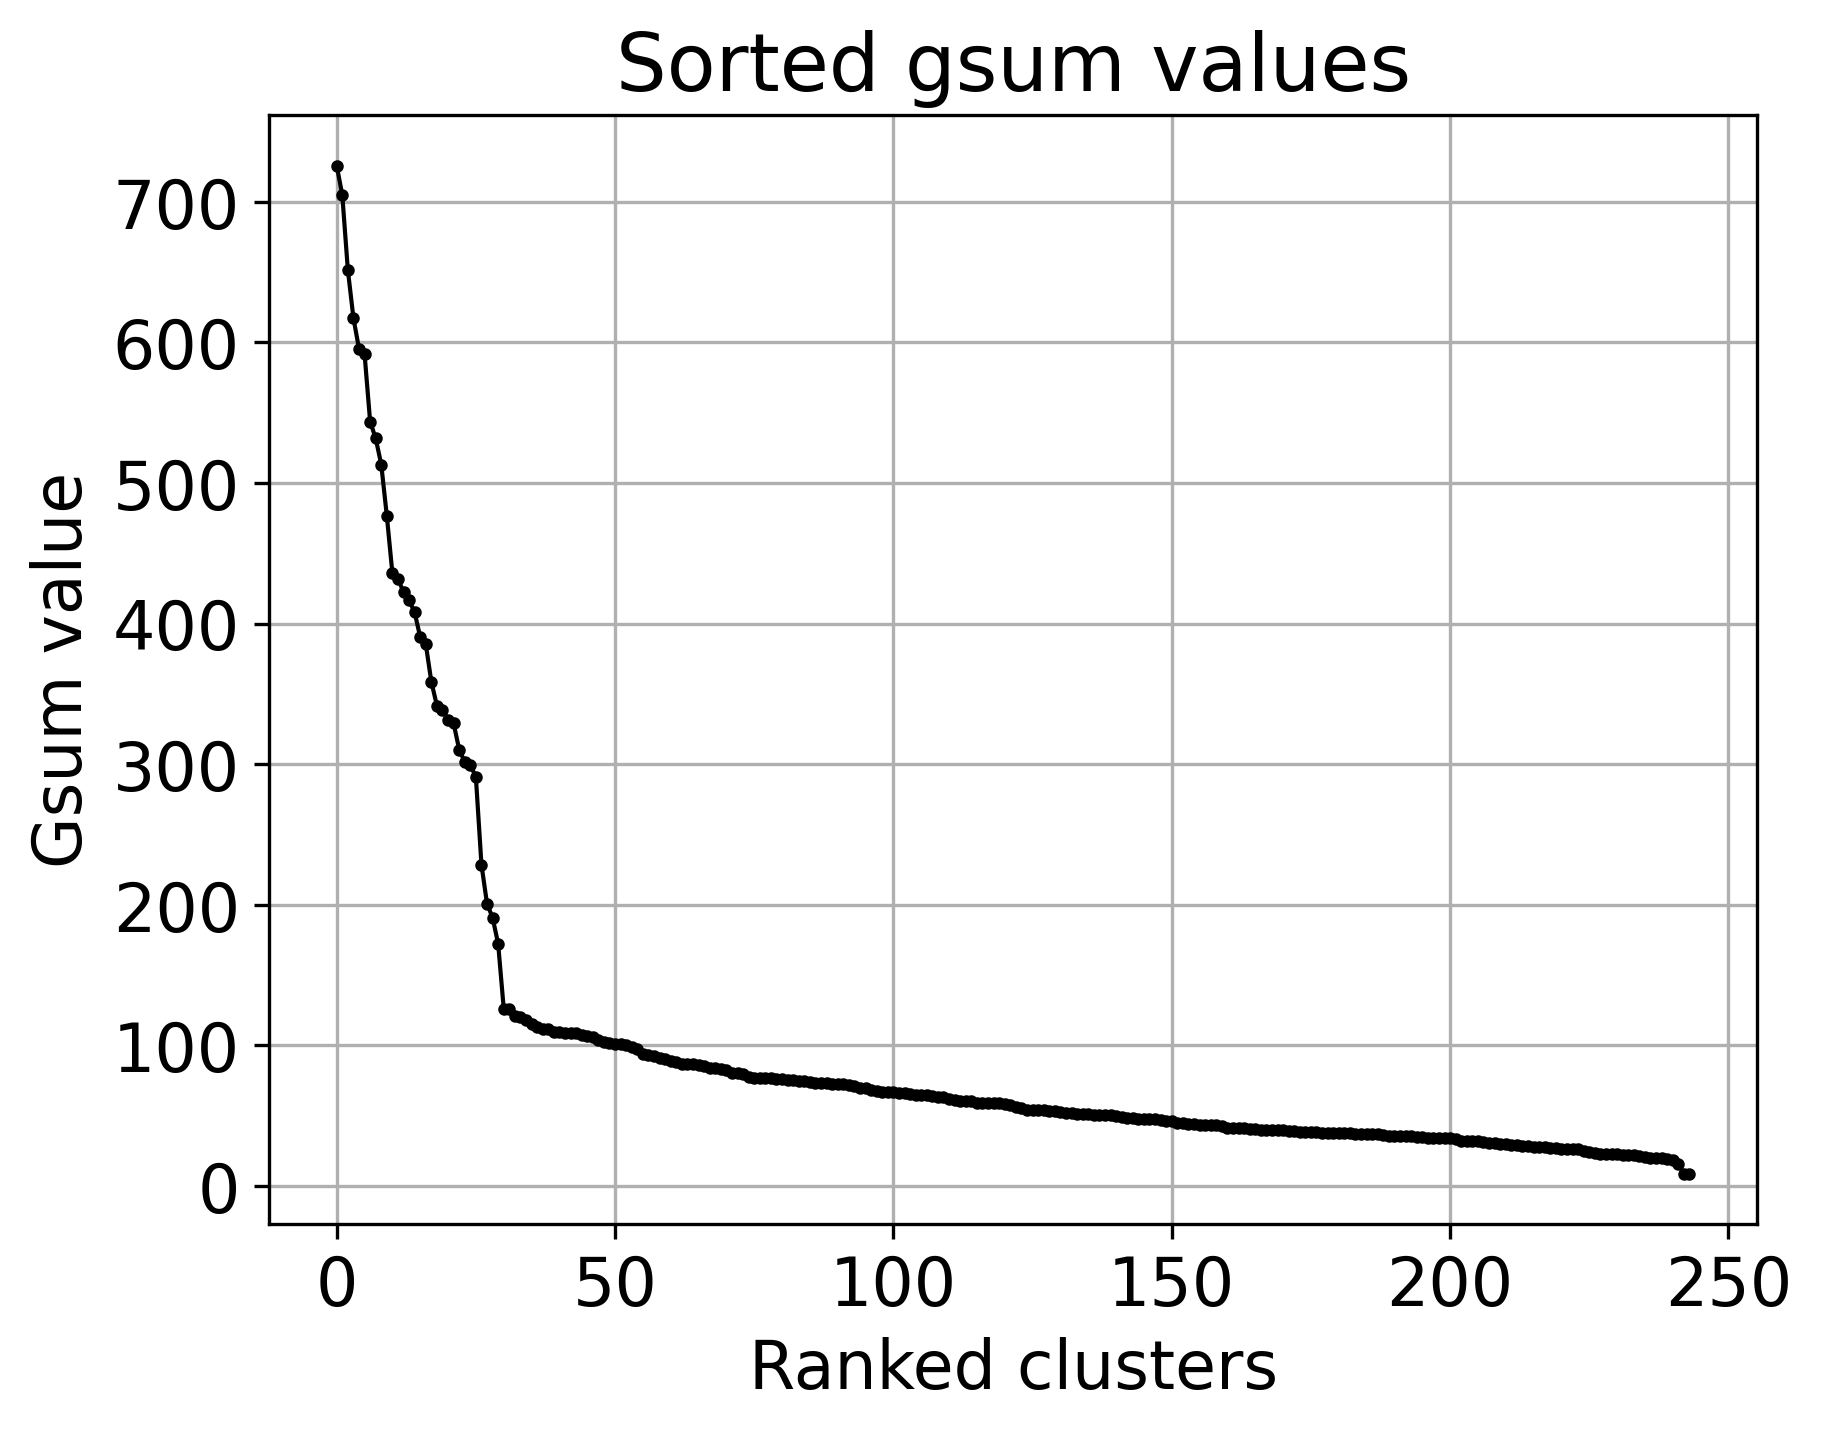

In [10]:
os.chdir(original_path) # recover the original path

file_path = 'som_results/SCE/'
file_name = 'multimap_mappings.txt'

from aweSOM.make_sce_clusters import get_gsum_values, plot_gsum_values

ranked_gsum_list, map_list = get_gsum_values(file_path+file_name)

plot_gsum_values(ranked_gsum_list)

In the simplest case, add all gsum values together to obtain final SCE clustering result

In [11]:
number_of_points = int(128**3)

sce_sum = np.zeros((number_of_points))

for i in range(len(ranked_gsum_list)):
    current_cluster_mask = np.load(f"{file_path}/mask-{map_list[i][2]}-id{map_list[i][1]}.npy")
    sce_sum += current_cluster_mask

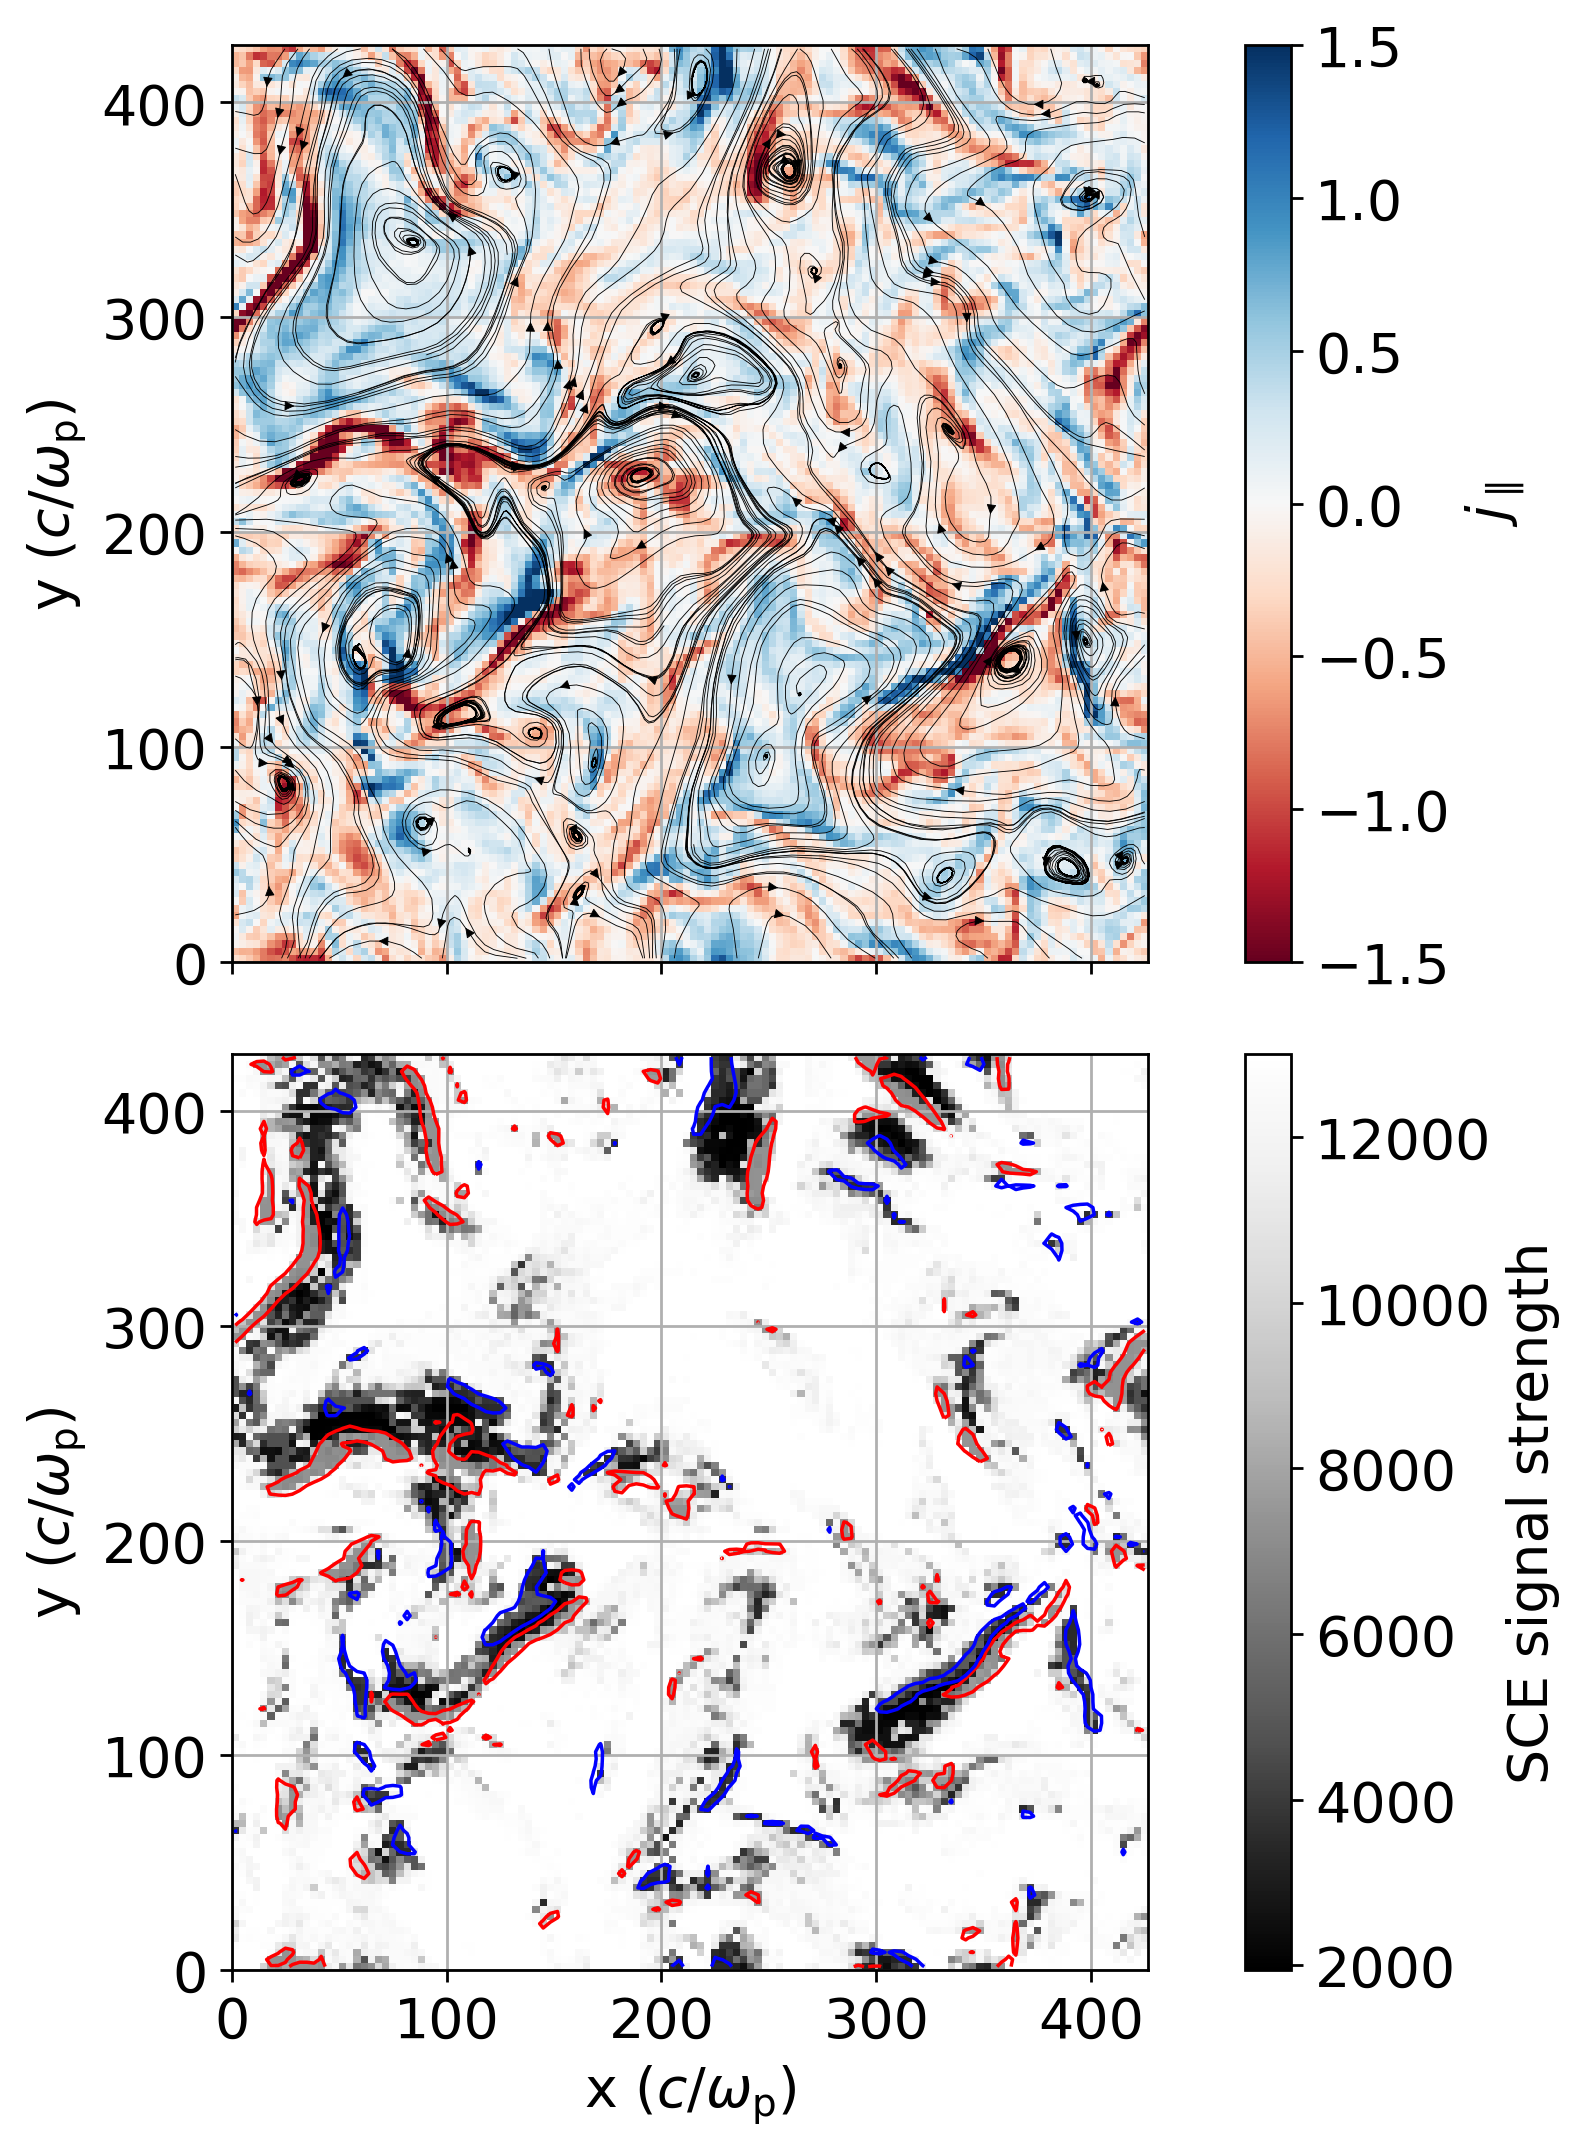

In [12]:
sce_sum_transformed = sce_sum.reshape((128,128,128))

slice_numbers = [27]

for slice_number in slice_numbers:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=250, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    jmag_plot = ax[0].pcolormesh(j_par[slice_number], cmap='RdBu', clim=[-1.5,1.5], rasterized=True)
    fig.colorbar(jmag_plot, ax=ax[0], fraction=0.042, pad=0.05, label=r'$j_{\parallel}$', ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], location="right")
    # ax[0].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors='green', linewidths=1, linestyles='solid')
    ax[0].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1., integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    # fig.colorbar(eperp_plot, ax=ax[0], fraction=0.042, pad=0.04, label=r'$E_{\perp}$', ticks=[0, 0.1, 0.2, 0.3])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].grid()
    # ax[0].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[0].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax[0].set_xlabel(r'x ($c/\omega_p$)')
    ax[0].set_ylabel(r'y ($c/\omega_{\rm p}$)')
    # ax[0].set_title(f'z = {slice_number*dx:.0f} '+ r'$c/\omega_{\rm p}$')

    cluster_plot = ax[1].pcolormesh(sce_sum_transformed[slice_number], cmap='Greys_r', rasterized=True)
    cbar = fig.colorbar(cluster_plot, ax=ax[1], fraction=0.042, pad=0.05, label='SCE signal strength', location="right")
    # cbar.ax.set_yticklabels(np.arange(0, len(set(som_labels))))
    ax[1].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors=['red','blue'], linewidths=1, linestyles='solid')
    # ax[1].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1, integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].grid()
    ax[1].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_xlabel(r'x ($c/\omega_{\rm p}$)')
    ax[1].set_ylabel(r'y ($c/\omega_{\rm p}$)')

    plt.show()

Let's visualize the distribution of these SCE signal strengths

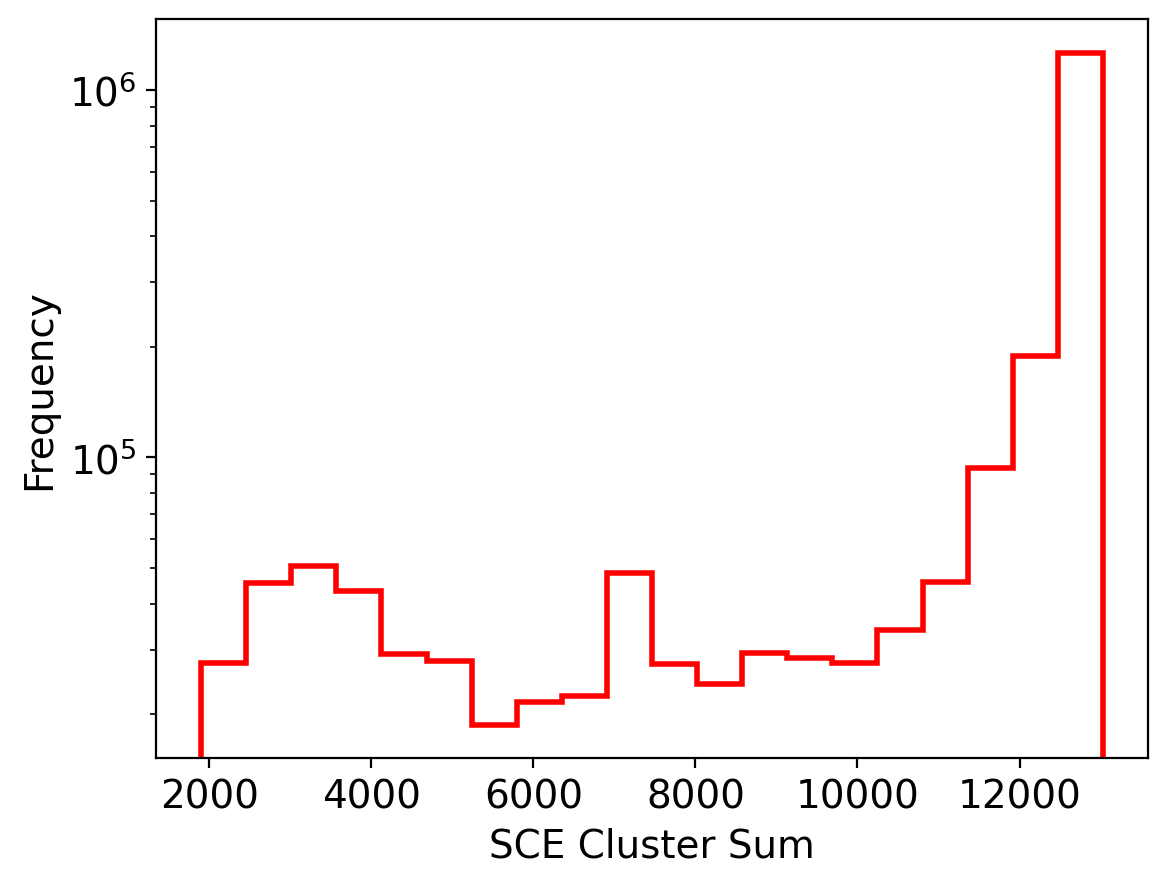

In [13]:
plt.rcParams.update({'font.size': 14})
plt.figure(dpi=200)
plt.hist(sce_sum, bins=20, color='r', label='SCE Cluster Sum', histtype='step', linewidth=2)
plt.xlabel('SCE Cluster Sum')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

Set a cutoff

In [19]:
signal_cutoff = [3500, 6000, 10000]

sce_clusters = np.zeros(number_of_points, dtype=int)
for i in range(len(sce_sum)):
    if sce_sum[i] < signal_cutoff[0]:
        sce_clusters[i] = 0
    elif sce_sum[i] < signal_cutoff[1]:
        sce_clusters[i] = 1
    elif sce_sum[i] < signal_cutoff[2]:
        sce_clusters[i] = 2
    else:
        sce_clusters[i] = 3

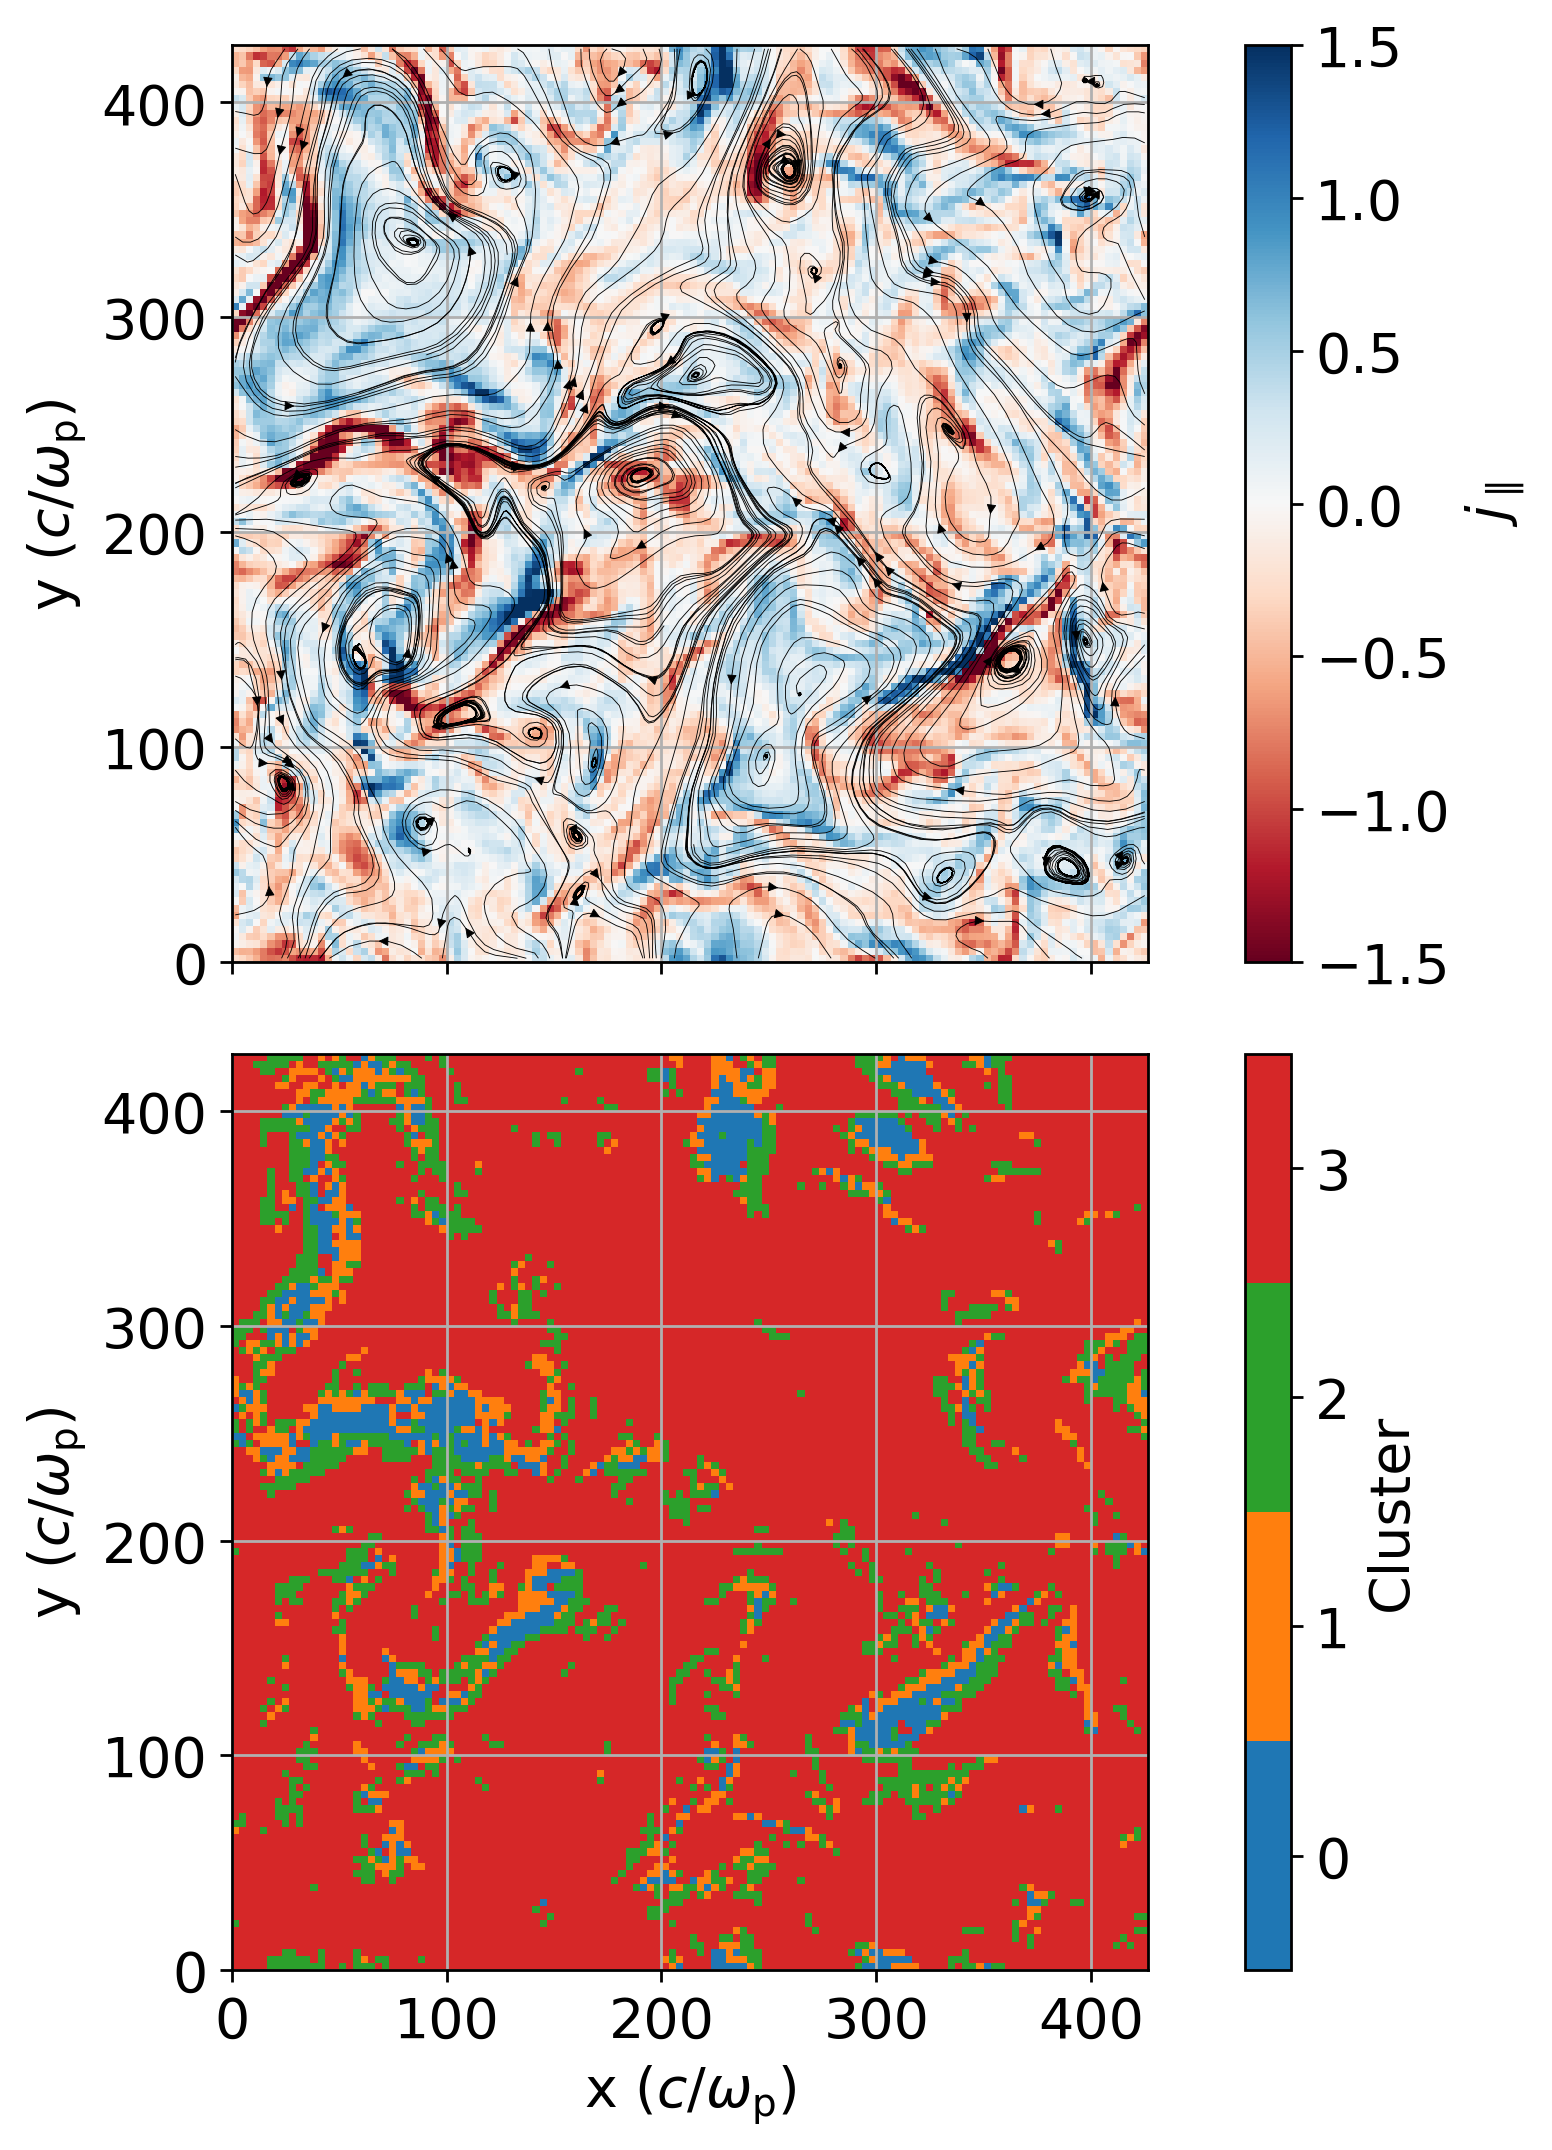

In [20]:
sce_clusters_transformed = sce_clusters.reshape((128,128,128))

plt.rcParams.update({'font.size': 16})

slice_numbers = [27]

for slice_number in slice_numbers:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=250, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    jmag_plot = ax[0].pcolormesh(j_par[slice_number], cmap='RdBu', clim=[-1.5,1.5], rasterized=True)
    fig.colorbar(jmag_plot, ax=ax[0], fraction=0.042, pad=0.05, label=r'$j_{\parallel}$', ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], location="right")
    # ax[0].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors='green', linewidths=1, linestyles='solid')
    ax[0].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1., integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    # fig.colorbar(eperp_plot, ax=ax[0], fraction=0.042, pad=0.04, label=r'$E_{\perp}$', ticks=[0, 0.1, 0.2, 0.3])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].grid()
    # ax[0].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[0].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax[0].set_xlabel(r'x ($c/\omega_p$)')
    ax[0].set_ylabel(r'y ($c/\omega_{\rm p}$)')
    # ax[0].set_title(f'z = {slice_number*dx:.0f} '+ r'$c/\omega_{\rm p}$')

    cluster_plot = ax[1].pcolormesh(sce_clusters_transformed[slice_number], cmap='tab10', clim=[0,10], rasterized=True)
    cbar = fig.colorbar(cluster_plot, ax=ax[1], fraction=0.042, pad=0.05, label='Cluster', ticks=np.arange(0, len(signal_cutoff)+1)+0.5, boundaries=np.arange(0, len(signal_cutoff)+2), location="right")
    cbar.ax.set_yticklabels(np.arange(0, len(signal_cutoff)+1))
    # ax[1].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors=['red','blue'], linewidths=1, linestyles='solid')
    # ax[1].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1, integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].grid()
    ax[1].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_xlabel(r'x ($c/\omega_{\rm p}$)')
    ax[1].set_ylabel(r'y ($c/\omega_{\rm p}$)')

    plt.show()